# Overview

## About this file

* This [IPython Notebook](http://ipython.org/notebook.html) 
demonstrates the use of metaseq for exploring RNA-seq data.


* If you are viewing this locally on your own machine:

    - you should be able to use Shift-Enter on each cell to run it and see the results interactively.
    
    - If you prefer, you can download this notebook as a Python script (`File -> Download as -> Python`). Note that you will have to delete or comment out the lines that start with `get_ipython().magic`, since these are Notebook-only calls.
    

## Viewing plots

The command **`%matplotlib inline`** will make plots show up inside the Notebook as static images.


The command **`%matplotlib`** will make plots show up in their own separate window, which means you can pan, zoom, and otherwise interact with them.  In some cases, Mac OSX will show empty figures when using `%matplotlib inline`; in this case, use `%matplotlib` to have the plots show up in a different window.

In [1]:
# Show plots inline.  If it doesn't seem like plots are 
# showing up correctly below, try deleting the "inline" and
# then run this cell again.
%matplotlib inline

## Biological background
**K562** is an immortalized cell line from a patient with chronic myleogenous leukemia, used as a model for erythropoeisis.

**H1-hESC** cells are a human embryonic stem cell line.

**Gata1** and **Tal1** are transcription factors that play a role in erythroid differentiation.

Our goal is to create a scatterplot highlighting differentially expressed genes as well as those that have a Gata1 and Tal1 peak near their promoter.

We will do some exploration of the data on the way.

## Data acquisition

All data are from the ENCODE project and are downloaded and prepared using the [`download_data.bash`](files/download_data.bash) script.  This script downloads data from the ENCODE project and only extracts data from chromosome 11 in order to keep this example running quickly.


Downloaded data include:
  - BAM files for RNA-seq in K562 and H1-hESC cell lines, 2 replicates each.
  - BAM file for H3K4me3 ChIP-seq in K562 cells (*not used in this script*)
  - narrowPeak (a BED-like format) files of called peaks from Gata1 and Tal1
    ChIP-seq experiments in K562 cells

The R script [`RNA-seq.R`](files/RNA-seq.R) performs differential expression analysis between K562 and H1-hESC cells using DESeq2. See that file for more details.

Scatter plot of K562 vs H1-hESC expression, with genes containing TAL1+GATA1 peaks within 1.5kb of a gene.

Clicking on a point queries the mygene.info service, prints gene ontology details, and opens the UCSC genome browser to that gene's locus.

# Imports
The following modules will be used in the code below.  If you are unfamiliar with them here is a brief description and justification for their use:

* [`os`](https://docs.python.org/2/library/os.html) is a built-in module used for working with files on disk

* [`webbrowser`](https://docs.python.org/2/library/webbrowser.html) is a built-in module. We will use it to open a gene's locus on the UCSC Genome Browser

* [`numpy`](http://www.numpy.org/)(is the de facto standard for working with arrays of data.  By convention it is imported as the abbreviated name `np`.

* [`metaseq`](https://pythonhosted.org/metaseq/) is what this code is demonstrating

* [`matplotlib`](http://matplotlib.org/) is a powerful plotting library.  We will be using the so-called "pyplot" interface, which is by convention imported as the abbreviated name `plt`.  We also import the top-level `matplotlib` module so we can access things like colormaps.

* [`gffutils`](https://pythonhosted.org/gffutils/) is a package for working with annotation data. Specifically it creates sqlite databases from GTF or GFF files.  We will use it to interface with an already-created database for retrieving things like the genomic coordinates of genes.

* [`pybedtools`](http://pythonhosted.org/pybedtools/) wraps and extends the popular BEDTools suite for "genomic algebra".  We will use it to manipulate genomic intervals (e.g., intersect two sets of peaks).  The featurefuncs submodule of pybedtools provides convenient tools for manipulating features. We will use the TSS function.

* [`mygene`](https://pypi.python.org/pypi/mygene) allows us to query and interface with the [MyGene.info](http://mygene.info/) service.  We will use this to get gene ontology information for genes that we click on.

* [`yaml`](http://pyyaml.org/wiki/PyYAML) is used as a convenient way of formatting gene info.  It is a module for working with YAML format data.

In [2]:
import os
import webbrowser
import numpy as np
import metaseq
from matplotlib import pyplot as plt
import matplotlib
import gffutils
import pybedtools
from pybedtools import featurefuncs as ff
import mygene
import yaml

In [3]:
# show what version of metaseq we're using
print metaseq.__version__

0.5.5.3


# Configuration

Next, we set up some configuration -- fonts, font sizes, where the files are to be found, and some constants that we will be using later. Everything is defined here at the top of the script so that it can be easily changed in the future.

## Change default style
This makes matplotlib's plotting defaults a little nicer

In [4]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.scatterpoints'] = 1
plt.rcParams['legend.fontsize'] = 10

## Set up filenames
### `gffutils` database
This filename points to the already-created gffutils database. It contains all [GENCODE v19](http://www.gencodegenes.org/releases/19.html) annotations from chromosome 11.  See [`download_data.bash`](files/download_data.bash) for details on how it was created.

In [5]:
dbfn = 'data/gencode.v19.annotation.chr11.db'

### Differential expression results
This filename points to the already-created DESeq2 results file. See [`RNA-seq.R`](files/RNA-seq.R) for details on how it was created. Note that it only contains DE results for genes on chromosome 11.

In [6]:
deseq_results_filename = 'data/DESeq-results.txt'

### Called peaks ###
This dictionary keeps track of multiple files of called peaks.  There are only two files here for now, but this can be easily extended.  These files were downloaded from ENCODE (see the [`download_data.bash`](files/download_data.bash) file for details).


In [7]:
peaks = {
    'gata1': 'data/K562_GATA1.narrowPeak',
    'tal1': 'data/K562_TAL1.narrowPeak',
}

### Optionally move db to local storage ###
This is a performance tweak for cluster environments (e.g., NIH's biowulf or Amazon's AWS) that use networked storage. If it doesn't already exist, we copy the `gffutils` database to a local directory (`/tmp` by default) that has fast local storage. The reason is that this is a sqlite3 database, a a kind of database known to be slow on networked filesystems.

In [8]:
cache_dir = '/tmp'
cached_db = os.path.join(cache_dir, os.path.basename(dbfn))
if not os.path.exists(cached_db):
    os.system('cp -v %s %s' % (dbfn, cached_db))

# Using `metaseq`

With the setup out of the way, here's our first use of `metaseq`.

This sets up a `DESeq2Results` object by providing the filename (which we defined above) to the results file.  As we will see, creating this object allows us to manipulate the results easily.

In [9]:
d = metaseq.results_table.DESeq2Results(deseq_results_filename)

Right away, we can make an M-A plot by providing an adjusted p-value to use as the cutoff.  The `DESeq2Results` object knows to look for the `baseMean` and `log2FoldChange` columns for the x and y values, and to use the `padj` column for determining statistical significance.

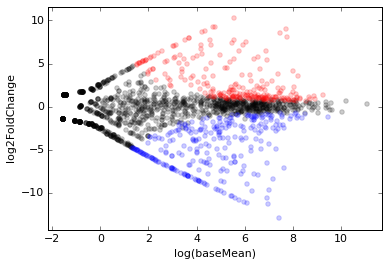

In [10]:
d.ma_plot(0.05);

Genes that are upregulated in K562 cells relative to H1-hESC cells are in red; downregulated in blue.

Gata1 and Tal1 are erythroid transcription factors.  We might expect genes upregulated in K562 cells to have more Gata1 and Tal1 peaks near their promoters compared to non-upregulated genes.

In order to create a list of especially interesting regions, let's use `pybedtools` to intersect the Gata1 and Tal1 peaks.  This gets us regions where both proteins are bound.  The result of the `intersect()` call is a `pybedtools.BedTool` object, which we store in the `peaks` dictionary at the `'both'` key for later use.

In [11]:
peaks['both'] = pybedtools.BedTool(peaks['gata1']).intersect(peaks['tal1'])

Next, we need to get promoter regions.

DESeq results are keyed by gene ID, but we need the genomic coordinates of those genes in order to get promoters. This is where `metaseq` helps. Here, we connect to the `gffutils` database, and use the `attach()` method of the `DESeq2Results` object to attach this database.  This lets us get the features for genes in the DESeq results and this is where the link happens between ID-based data (DESeq results) and interval-based data (genomic coordinates of those genes).

In [12]:
db = gffutils.FeatureDB(cached_db)
d.attach_db(db)

The `genes_with_peak` method of a `DESeq2Results` object is a flexible way of exploring sets of peaks and different settings for how to define "promoter".

In the literature, authors will typically choose the 5'-most TSS of a gene's alternative transcripts and extend it by some distance to define "promoter region".

Here, we will use a transform function that operates on each gene, returning a promoter region of whatever size we choose.  Then, these promoter regions will be intersected with the provided peaks.  The result will be a boolean NumPy array, the same size as the DESeq results, that is True wherever a gene had at least one peak in its promoter region.

In [13]:
with_both = d.genes_with_peak(

    # The peaks to use
    peaks['both'],

    # What attribute contains the gene ID in the database?
    # By default it's "ID", but the GENCODE v19 GTF annotations 
    # we're using store the ID in the "gene_id" attribute.
    id_attribute='gene_id',

    # By default, the entire gene region is used.  Here, we use the 
    # pybedtools.featurefuncs.TSS function which will return 
    # the 5' end.
    transform_func=ff.TSS,

    # Any extra arguments are passed to the transform_func.
    # So here  we're asking for 1.5kb upstream of each gene.
    upstream=1500,
    downstream=0,
)

Since it's a boolean array, taking the sum tells us how many genes.

In [14]:
print sum(with_both)

38


OK, so 38 genes have a Gata1 and Tal1 peak within 1.5 kb upstream of their promoter reigion.

## Fisher's exact test
We can easily try different promoter regions, but let's stick with our original of 1.5kb upstream.  Are upregulated genes significantly enriched for Gata1+Tal1 peaks within 1.5kb upstream?

In [15]:
import fisher

print "\n\nUpregulated genes"

# Uses padj <= 0.05 by default
up = d.upregulated()

table = [
    up & with_both,
    up & ~with_both,
    ~up & with_both,
    ~up & ~with_both
]
table = map(sum, table)
kwargs = dict(
    table=table,
    row_labels=['upregulated', 'not'],
    col_labels=['with peak', 'no peak'])
print metaseq.tableprinter.print_2x2_table(**kwargs)
print metaseq.tableprinter.print_row_perc_table(**kwargs)
print fisher.pvalue(*table)


print "\n\nDownregulated genes"

# Uses padj <= 0.05 by default
dn = d.downregulated()
table = [
    dn & with_both,
    dn & ~with_both,
    ~dn & with_both,
    ~dn & ~with_both
]
table = map(sum, table)
kwargs = dict(
    table=table,
    row_labels=['downregulated', 'not'],
    col_labels=['with peak', 'no peak'])
print metaseq.tableprinter.print_2x2_table(**kwargs)
print metaseq.tableprinter.print_row_perc_table(**kwargs)
print fisher.pvalue(*table)



Upregulated genes
=========== ========= ======= =====
            with peak no peak total
=========== ========= ======= =====
upregulated 11        217     228  
not         27        2953    2980 
total       38        3170    3208 
=========== ========= ======= =====

=========== ========= ======= =====
            with peak no peak total
=========== ========= ======= =====
upregulated 0.05      0.95    1.00 
not         0.01      0.99    1.00 
=========== ========= ======= =====

Pvalue(left_tail=1, right_tail=3.973e-05, two_tail=3.973e-05)


Downregulated genes
============= ========= ======= =====
              with peak no peak total
============= ========= ======= =====
downregulated 4         276     280  
not           34        2894    2928 
total         38        3170    3208 
============= ========= ======= =====

============= ========= ======= =====
              with peak no peak total
============= ========= ======= =====
downregulated 0.01      0.99    1.00 
not    

So about 5% of genes upregulated in K562 have a Gata1+Tal1 peak near their promoter compared to about 1% of all other genes; this is a statistically significant enrichment.  Downregulated K562 genes have no such enrichment of Gata1+Tal1 peaks.

Phew, this is consistent with Gata1 and Tal1 being known activators.

# Building up a scatterplot
In this next section, we'll re-create the M-A plot but do it in a more flexible way.  Then we'll demonstrate different ways
of highlighting genes with a peak on the plot, and then define different behaviors when we click on a point interactively.

Note that `d.data` is a `pandas.DataFrame` of the differential expression data, so there's a lot we can do with it.  For example, here are the columns we have available for use:

In [16]:
d.data.columns

Index([u'baseMean', u'log2FoldChange', u'lfcSE', u'stat', u'pvalue', u'padj'], dtype='object')

And here's a summary of the data.  So we can see that there are 3208 genes, and it looks like 1734 of them have a pvalue associated with them:

In [17]:
print len(d.data)
d.data.describe()

3208


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
count,3208.000000,1734.000000,1734.000000,1734.000000,1.734000e+03,1.237000e+03
mean,271.764957,-0.515361,1.242603,-0.364152,3.102941e-01,2.959634e-01
std,1606.799684,2.818675,0.803170,3.196358,3.011472e-01,3.321577e-01
min,0.000000,-12.953026,0.284911,-19.268053,9.961351e-83,1.232219e-79
25%,0.000000,-1.785454,0.400634,-1.370421,7.145208e-03,1.871408e-03
50%,0.243569,-0.139655,1.124026,-0.180565,2.691684e-01,1.227084e-01
75%,35.981287,0.959718,2.215022,0.996161,5.321646e-01,6.017470e-01
max,64177.926549,10.326326,2.288970,16.742054,9.984767e-01,9.984767e-01


The `DESeq2Results` object has some other handy methods. One of them not explored further here is `d.colormapped_bedfile()`, which creates a BED file where genes are colored by their enrichment.  Uploading this to the UCSC Genome Browser is a great way to get a feel for spatial patterns in differential expression.

Let's re-create the M-A plot by specifying which variables to use as x and y.  We also provide a transform function for x to put it on a log scale.  We don't need to do that for the y axis since it's already on a log scale.

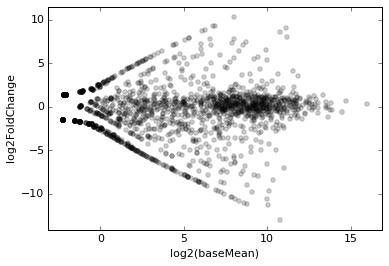

In [18]:
d.scatter(
    x='baseMean',
    y='log2FoldChange',
    xfunc=np.log2,
    );

This shows how to highlight particular genes of interest: we provide a boolean array of genes to highlight and a style.
The style is passed to `matplotlib.scatter`, which has many options you can look up.

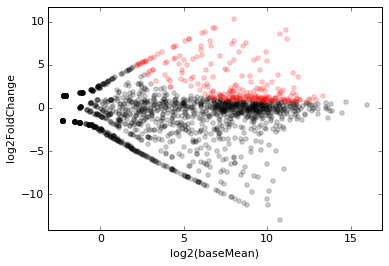

In [19]:
d.scatter(
    x='baseMean',
    y='log2FoldChange',
    xfunc=np.log2,
    genes_to_highlight=[
        (
            d.upregulated(),  # which genes to highlight
            dict(color='r'),  # style
        )
]
    );

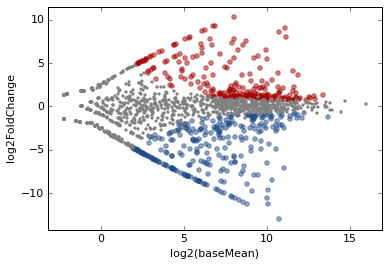

In [20]:
d.scatter(
    x='baseMean',
    y='log2FoldChange',
    xfunc=np.log2,
    genes_to_highlight=[
        (d.upregulated(), dict(color='#a40000', alpha=0.5)),
        (d.downregulated(), dict(color='#204a87', alpha=0.5)),
        (d.unchanged(), dict(marker='.', color='0.5', alpha=1)),
]
    );

Recall that `with_both`, which tells us which genes have a peak, is also a boolean array.  Let's use that, too.  While we're at it, clean up the layout of the code a little to make things more clear, and add a legend.

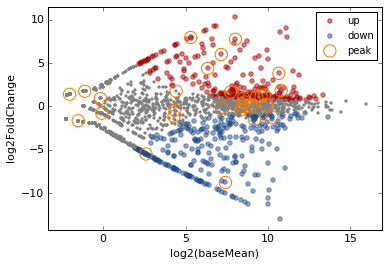

In [21]:
ax = d.scatter(
    x='baseMean',
    y='log2FoldChange',
    xfunc=np.log2,
    genes_to_highlight=[
        (
            d.upregulated(),
            dict(color='#a40000', alpha=0.5, label='up')
        ),
        (
            d.downregulated(),
            dict(color='#204a87', alpha=0.5, label='down')
        ),
        (
            d.unchanged(),
            dict(marker='.', color='0.5', alpha=1)
        ),
        (
            with_both,
            dict(s=150, color='#f57900', facecolors='None',
                 linewidth=1, alpha=1.0, picker=None, 
                 label='peak'),
        ),

        (
            d.index.isin(['ENSG00000196565.10']),
            dict(s=100, color='b', alpha=1)
        )
]
    )
ax.legend(loc='best');

# Callbacks

* A "callback" is a function that is triggered when something is clicked.  Callbacks allow us to attach all sorts of behavior to our scatterplot.

* A callback function is written such that it accepts a gene ID, and then does something with it.

* Here are some useful callbacks:

    * The first one, `go_callback`, queries the mygene.info web service and prints the info for gene ontology terms and the gene name and symbol.
    
    * The second one, `ucsc()`, queries the `gffutils` database and opens your web browser to the UCSC Genome Browser for that location (after zooming the coordinates out by 10% for a nicer view).
    
    * The third one, `do_both()`, simply calls both of these and shows how easy it is to build up complex and interesting    callbacks upon clicking a gene.

In [22]:
# Set up the connection to the mygene.info service
mg = mygene.MyGeneInfo()

def go_callback(x):
    """
    Queries the mygene.info service, and asks for gene ontology terms
    as well as name, symbol, and ensembl IDs for this gene.
    """
    ms = mg.getgene(
        # GENCODE annotations have a trailing numeric "extension" after
        # the Ensembl ID.  Here we extract just the Ensembl ID.
        x.split('.')[0],
        fields=[
            'go.CC.term',
            'go.MF.term',
            'go.BP.term',
            'name',
            'symbol',
            'ensembl.gene']
    )
    # `ms` is a nested dictionary that can be awkward to read.
    # Here we use the yaml module to display a nicely-formatted
    # version.
    print yaml.safe_dump(ms, default_flow_style=False)
    
    # Flush the output. Needed for the IPython Notebook to
    # immediately show the printed text.
    import sys
    sys.stdout.flush()


def ucsc(x):
    """
    Opens up the UCSC Genome Browser in a new window, 
    showing the coordinates of the gene in the hg19 assembly.
    """
    g = db[x]
    frac = int(len(g) * 0.1)
    g.start -= frac
    g.stop += frac
    url = (
        'http://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19'
        '&position={0.chrom}%3A{0.start}-{0.stop}'
        ).format(g)
    print url
    webbrowser.open(url)
    

def do_both(x):
    go_callback(x)
    ucsc(x)

To use them, we simply use the `callback` argument in `d.scatter`.

So far, we have been using the `%matplotlib inline` command for the IPython notebook, which conveniently shows the plots directly in the notebook.  However, these plots are not interactive, and we need interactive plots in order for the callbacks to work.

The following command will reset behavior to spawn a new window instead.

In [23]:
%matplotlib

# uncomment this line to show in the notebook:
%matplotlib inline

Using matplotlib backend: Qt4Agg


Note that we have highlighted some genes twice: any gene with a peak is also marked as up, down, or unchanged.  This means that when we click the mouse over a point, the callback would be triggered twice, which can get annoying.

The trick is to selectively disable the callback on the peaks by including `picker=None` in the style.

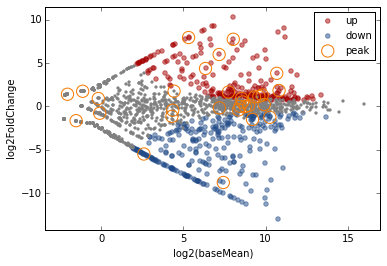

In [24]:
ax = d.scatter(
    x='baseMean',
    y='log2FoldChange',
    xfunc=np.log2,
    genes_to_highlight=[
        (
            d.upregulated(),
            dict(color='#a40000', alpha=0.5, label='up')
        ),
        (
            d.downregulated(),
            dict(color='#204a87', alpha=0.5, label='down')
        ),
        (
            d.unchanged(),
            dict(marker='.', color='0.5', alpha=1)
        ),
        (
            with_both,
            dict(s=150, color='#f57900', facecolors='None',
                 linewidth=1, alpha=1.0, picker=None,
                 label='peak'),
        ),

        (
            d.index.isin(['ENSG00000196565.10']),
            dict(s=100, color='b', alpha=1)
        )
    ],
    callback=go_callback,
)
ax.legend(loc='best');

# Biotypes
This is a somewhat more advanced example, but it demonstrates how flexible the `metaseq` plotting mechanisms can be.

We will: 

* attach information to the underlying dataframe (biotype information for each gene)

* build a `genes_to_highlight` list, assigning a color to each biotype based on a colormap and highlighting changed genes of that biotype

* make a scatterplot as before, but this time we ask for marginal histograms.

Comments are included in-line:


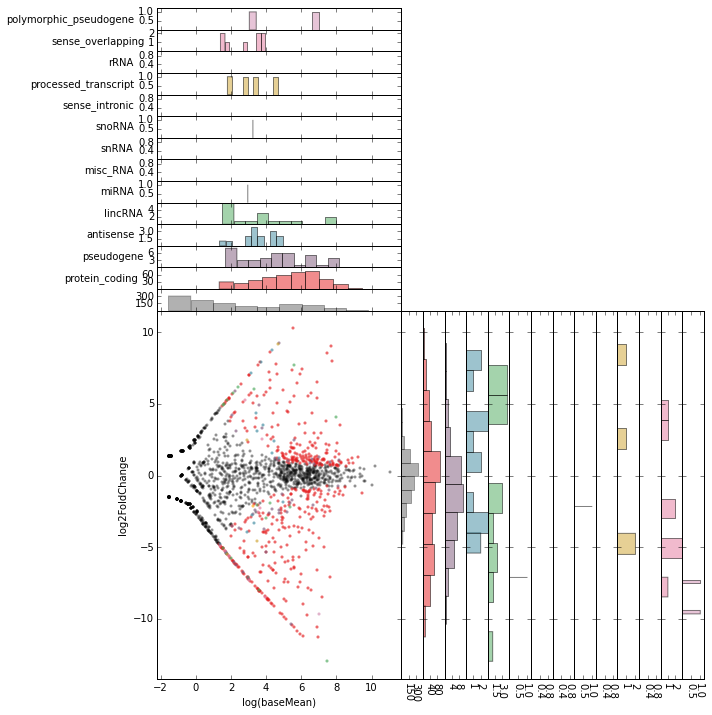

In [25]:
# 
# d.data.index contains gene IDs.  These are iterated over (`i`) and 
# used to query the database (`db`) for the corresponding gene ID. 
# This returns a gffutils.Feature object, and the
# gene_type field is extracted from the attributes for that feature;
# the gene_type field is a one-item list so we just grab the first item (`[0]`).
# Last, we add that information to the underlying pandas.DataFrame as a
# new column, "biotype".
d.data['biotype'] = [db[i]['gene_type'][0] for i in d.data.index]

# Using built-in pandas functionality, this ranks the biotypes 
# by frequency of occurrence
biotypes = d.data['biotype'].value_counts().index

# Set up an empty list we'll be incrementally building
genes_to_highlight = []

# The colormap to use
cmap = matplotlib.cm.Set1

# Iterate over the unique biotypes we've found
for i, biotype in enumerate(biotypes):

    # Generate a color based on the total number of biotypes
    color = cmap(i / float(len(biotypes)))
    
    # Append the boolean index -- where a gene is both changed and
    # is of this biotype; assign the label and color accordingly.
    genes_to_highlight.append(
        (
            (d.data['biotype'] == biotype) & ~d.unchanged(0.05),
            dict(color=color, label=biotype, alpha=0.5, picker=True),
        )
    )


def info(x):
    """
    Simply prints the pandas.DataFrame entry for the gene
    """
    print d.ix[x]

# Scatterplot; mostly the same as before except as noted below:
d.scatter(
    xfunc=np.log,
    yfunc=None,
    genes_to_highlight=genes_to_highlight,
    x='baseMean',
    y='log2FoldChange',

    # Sets the style of any genes not explicitly marked in
    # `genes_to_highlight`
    general_kwargs=dict(color='k', alpha=0.3, marker='.'),

    # Enables marginal histograms
    marginal_histograms=True,

    # We need to make the figure larger to see everything!
    figure_kwargs=dict(figsize=(10,10)),
)

# Label the histograms along the top.
for biotype, ax in zip(biotypes, d.marginal.top_hists[1:]):
    ax.set_ylabel(biotype, rotation=0,
                  horizontalalignment='right',
                  verticalalignment='center')

# Tweak the formatting
plt.gcf().tight_layout()